# 15분 만에 Few-Shot 분류 모델 구현
https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb


Few-Shot 학습 방법 중 하나인 Prototypical Networks 구현을 빠르게 따라 해볼 수 있음을 안내합니다.

# easyfsl 라이브러리

In [1]:
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [8]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

easyfsl은 Few-Shot 학습용 데이터 샘플러(TaskSampler)와 시각화 도구(plot_images) 등을 제공합니다.

ResNet-18(resnet18)을 백본으로 사용하고, Omniglot 데이터셋을 다룹니다.

In [9]:
image_size = 28

train_set = Omniglot(
    root='./data',
    background=True,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    download=True,
)

test_set = Omniglot(
    root='./data',
    background=False,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15)]*2),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
    download=True,
)

100%|██████████| 9.46M/9.46M [00:00<00:00, 136MB/s]
100%|██████████| 6.46M/6.46M [00:00<00:00, 115MB/s]


Grayscale→3채널 변환: ResNet이 3채널 입력을 기대하므로 흑백 이미지를 채널 복제.

훈련용 랜덤 크롭/뒤집기, 테스트용 고정 크롭으로 데이터 증강/일관성 유지.

# Prototypical Networks

- 사용 용어 :

Support set: 라벨이 붙은 소수 이미지 집합

Query set: 예측 대상을 담은 이미지 집합

Prototypical Networks: 각 클래스의 prototype(평균 임베딩) 계산 후, 유클리드 거리로 분류

In [10]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([
            z_support[support_labels == label].mean(0, keepdim=True)
            for label in range(n_way)
        ], dim=0)

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores

backbone = resnet18(pretrained=True)
backbone.fc = nn.Flatten()
model = PrototypicalNetworks(backbone).cuda()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


- Backbone: 사전학습된 ResNet-18에서 마지막 FC 레이어를 제거하고 Flatten 레이어로 대체 → 512D 임베딩 출력

- Forward :

지원(support) 및 쿼리(query) 이미지의 임베딩 계산

클래스별로 임베딩 평균(prototype) 산출

쿼리 임베딩과 prototype 간 유클리드 거리 측정

거리에 음수 부호를 붙여 분류 점수로 변환

In [11]:
N_WAY = 5
N_SHOT = 5
N_QUERY = 10
N_EVALUATION_TASKS = 100

test_set.get_labels = lambda: [inst[1] for inst in test_set._flat_character_images]
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT,
                           n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_loader = DataLoader(test_set, batch_sampler=test_sampler,
                         num_workers=12, pin_memory=True,
                         collate_fn=test_sampler.episodic_collate_fn)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


get_labels 메서드 등록: 각 이미지의 라벨 인덱스 반환

TaskSampler: 에피소드(소수 클래스 과제)를 자동 생성

episodic_collate_fn: 지원/쿼리 집합을 모델 입력 형태로 묶어줌



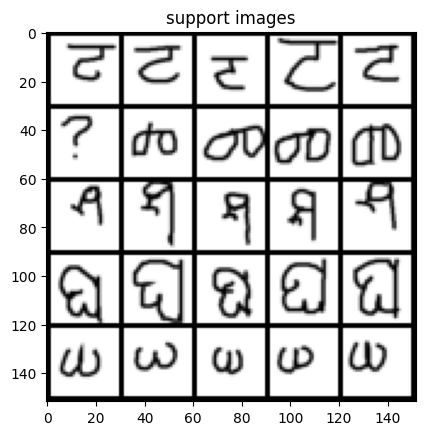

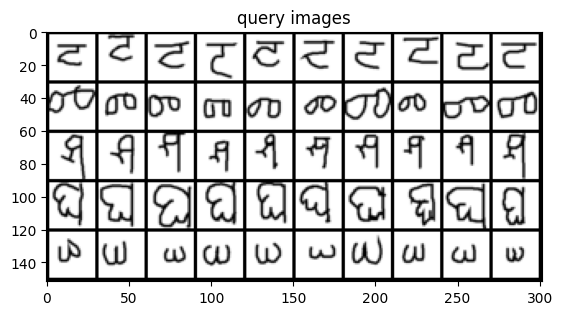

In [12]:
example_support_images, example_support_labels, \
example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images,   "query images",   images_per_row=N_QUERY)


plot_images로 각 클래스별 지원 이미지(Support image) 한 줄, 쿼리 이미지(query image) 한 줄 출력

데이터가 올바르게 에피소드 형태로 샘플링됐는지 시각적으로 검증

In [13]:
model.eval()
example_scores = model(example_support_images.cuda(),
                       example_support_labels.cuda(),
                       example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    gt = test_set._characters[example_class_ids[example_query_labels[i]]]
    pred = test_set._characters[example_class_ids[example_predicted_labels[i]]]
    print(f"{gt} / {pred}")

Ground Truth / Predicted
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Malayalam/character24
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Gurmukhi/character16 / Gurmukhi/character16
Ge_ez/character04 / Ge_ez/character04
Ge_ez/character04 / Malayalam/character24
Ge_ez/character04 / Malayalam/character24
Ge_ez/character04 / Ge_ez/character04
Ge_ez/character04 / Ge_ez/character04
Ge_ez/character04 / Ge_ez/character04
Ge_ez/character04 / Ge_ez/character04
Ge_ez/character04 / Malayalam/character24
Ge_ez/character04 / Ge_ez/character04
Ge_ez/character04 / Ge_ez/character04
Tibetan/character36 / Tibetan/character36
Tibetan/character36 / Tibetan/character36
Tibetan/character36 / Tibetan/character36
Tibetan/characte

torch.max로 가장 높은 점수(class) 선택

실제 글자(ground truth)와 예측 글자를 나란히 출력 → 모델 성능 감각 확인

In [23]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> (int, int):
    """
    하나의 few-shot 과제(에피소드)에 대해
    - support_images, support_labels: 지원 세트
    - query_images, query_labels: 쿼리 세트
    를 입력받아,
    모델의 예측 중 정답인 개수와 총 예측 개수를 반환합니다.
    """
    # 모델 출력(쿼리 점수) 계산
    scores = model(
        support_images.cuda(),
        support_labels.cuda(),
        query_images.cuda()
    )
    # 가장 높은 점수를 갖는 클래스를 예측 레이블로 선택
    _, predicted_labels = torch.max(scores.detach().data, dim=1)
    # 정답과 비교하여 맞힌 개수 계산
    correct = (predicted_labels == query_labels.cuda()).sum().item()
    total = query_labels.size(0)
    return correct, total

def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0
    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, _ in tqdm(data_loader):
            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )
            correct_predictions += correct
            total_predictions += total
    accuracy = 100 * correct_predictions / total_predictions
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2f}%")

# 평가 실행
evaluate(test_loader)

100%|██████████| 100/100 [00:05<00:00, 17.14it/s]

Model tested on 100 tasks. Accuracy: 87.62%


evaluate_on_one_task: 지원/쿼리 한 에피소드의 정답 수 반환

-> 오류 있어서 수정됨.

evaluate: 전체 에피소드 반복 → 누적 정확도 출력

결과 약 86% (학습 없이 ImageNet 사전학습만 사용)

In [21]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS   = 100

train_set.get_labels = lambda: [inst[1] for inst in train_set._flat_character_images]
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT,
                            n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES)
train_loader = DataLoader(train_set, batch_sampler=train_sampler,
                          num_workers=12, pin_memory=True,
                          collate_fn=train_sampler.episodic_collate_fn)

목적: 40,000개 에피소드로 학습용 DataLoader 구성

설명: 훈련용 Omniglot 문자와 테스트용 문자는 완전히 분리된 알파벳을 사용해 일반화 능력 보장

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def fit(support_images, support_labels, query_images, query_labels):
    optimizer.zero_grad()
    scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
    loss = criterion(scores, query_labels.cuda())
    loss.backward()
    optimizer.step()
    return loss.item()


손실 함수: Cross-Entropy

최적화기: Adam

메타학습 루프(fit):

에피소드마다 순전파→손실계산→역전파→파라미터 업데이트

In [24]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 40000/40000 [46:56<00:00, 14.20it/s, loss=0.329]


직접 학습: 약 40~50분 소요(하드웨어에 따라 상이)

sliding_average로 최근 손실 평균 표시

In [29]:
# 또는 사전학습 모델 로드
evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 20.74it/s]

Model tested on 100 tasks. Accuracy: 98.16%


사전학습 모델 사용: 빠르게 결과 확인 원할 때
-> 모델 파일 사라짐.

학습된 모델 사용 : 98.16%

목적: 학습된 모델을 동일한 평가 스크립트로 재검증

## What have we learned?
- Prototypical Network 구현 방법
- Omniglot을 이용한 평가
- Few-Shot용 DataLoader 구성
- 메타학습(episodic training) 절차

## What's next?
- 백본 변경, 거리 함수 실험
- Matching Networks, MAML 등 다른 방법 구현
- CUB, Meta-Dataset 등 더 어려운 벤치마크 적용
- 기여: easy-few-shot-learning 리포지토리에 PR!